In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm 

# Define ROIs 

In [2]:
label = {"standby_ASI": [(534, 424), 50, "c"], # [(cx,cy), radius, type: "c" = circle]  
         "standby_AH": [(528,530), 50, "c"],
         "standby_ALT": [(523, 626), 45, "c"], 
         "RPM_LEFT": [(633, 411), (672, 451), "r"], #[(topleft_x,y), (bottomright_x,y), type: "r" = rectangle]  
         "G1000_ASI": [(674, 432), (705, 525), "r"],
         "G1000_AI": [(720, 413), (790, 495), "r"],
         "HSI": [(742, 556), 45, "c"],
         "G1000_ALT": [(797, 428), (852, 523), "r"],
         "NRST_Box": [(792, 534), (876, 554), "r"],
         "RPM_RIGHT": [(1054, 440), 30, "c"],
         "outside": [(0,0), (1280, 350), "r"]} 

In [2]:
img = cv2.imread("flight.jpg")

overlay = img.copy()
thickness = -1

# overlay = cv2.circle(overlay, label["standby_ASI"][0], label["standby_ASI"][1], color, thickness)
# overlay = cv2.circle(overlay, label["standby_AH"][0], label["standby_AH"][1], color, thickness)
# overlay = cv2.circle(overlay, label["standby_ALT"][0], label["standby_ALT"][1], color, thickness)
# overlay = cv2.circle(overlay, label["HSI"][0], label["HSI"][1], color, thickness)
# overlay = cv2.circle(overlay, label["RPM_RIGHT"][0], label["RPM_RIGHT"][1], color, thickness)

# overlay = cv2.rectangle(overlay, label["RPM_LEFT"][0], label["RPM_LEFT"][1], color, thickness)
# overlay = cv2.rectangle(overlay, label["G1000_ASI"][0], label["G1000_ASI"][1], color, thickness)
# overlay = cv2.rectangle(overlay, label["G1000_AI"][0], label["G1000_AI"][1], color, thickness)
# overlay = cv2.rectangle(overlay, label["G1000_ALT"][0], label["G1000_ALT"][1], color, thickness)
# overlay = cv2.rectangle(overlay, label["NRST_Box"][0], label["NRST_Box"][1], color, thickness)

h,w,c = img.shape


In [4]:
pdict = defaultdict()

In [5]:
for key in label:
    if label[key][-1] == "c":
        mask = np.zeros((h,w), np.uint8)
        cv2.circle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points
    elif label[key][-1] == "r":
        mask = np.zeros((h,w), np.uint8)
        cv2.rectangle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points

In [6]:
cdict = {}
for key in pdict:
    cdict[key] = np.mean(pdict[key], axis = 1)

In [7]:
cdict["outside"][0] = 350
cdict["outside"]

array([350. , 639.5])

In [8]:
pdict["outside"]

(array([  0,   0,   0, ..., 350, 350, 350], dtype=int64),
 array([   0,    1,    2, ..., 1277, 1278, 1279], dtype=int64))

In [9]:
color = (0,255,0)

for key in pdict:
    overlay[pdict[key]] = color

In [10]:
alpha = 0.6

# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

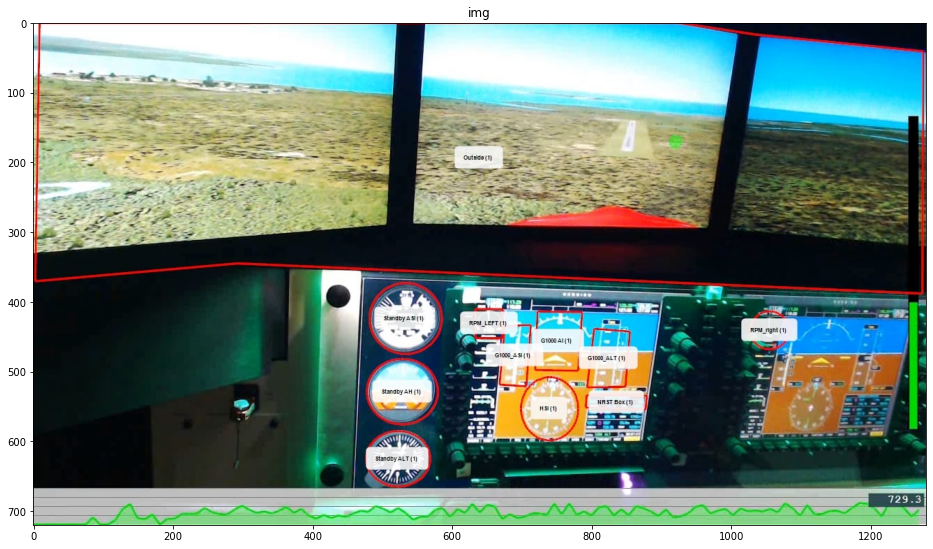

In [3]:
figure =plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('img')
plt.show()

# visualize gaze

In [12]:
csv_file = "data/PISSS_ID_033_Approach Two Gaze-Vergence.csv"

In [13]:
df_data = pd.read_csv(csv_file)

In [14]:
df_data = df_data.dropna()

In [15]:
x_offset = 10
y_offset = 20

df_data["X Pos"] = df_data["X Pos"] + x_offset


In [16]:
x = df_data[["Y Pos", "X Pos"]].values

In [17]:
x = np.array(x, dtype="int64")

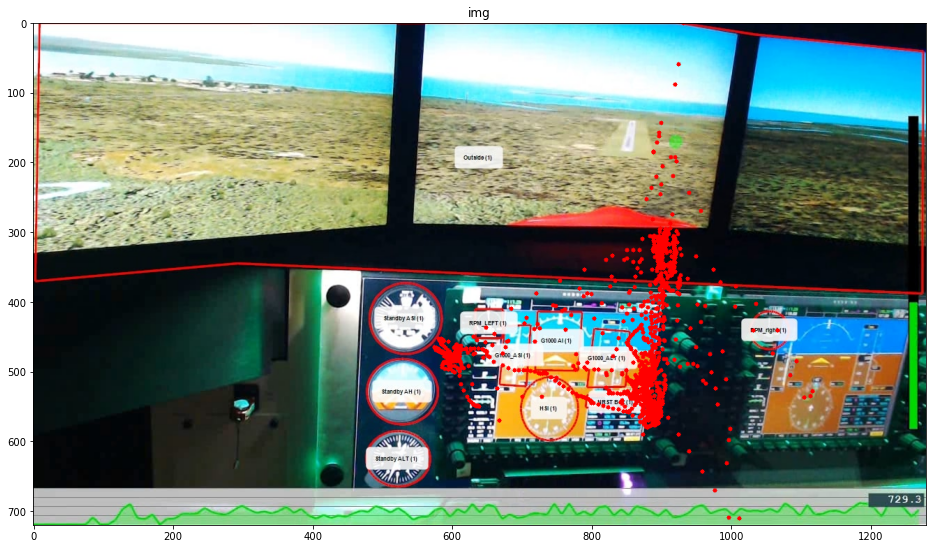

In [18]:
overlay = img.copy()
for p in x:
    overlay = cv2.circle(overlay, (p[1], p[0]), radius=3, color=(0, 0, 255), thickness=-1)

figure =plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('img')
plt.show()

In [113]:
def dist(x,y): #between 2 points
    return (x[0]-y[0])**2 + (x[1]-y[1])**2 

In [177]:
def dist2(point, v1, v2, type="c"): #between points and rectange/cirle
    #point: x, y
    #v1,v2: topleft,bottomright if type = "r"
    #v1,v2: center (x,y),  if type = "c"
    d = 0
    if type == "r":
        dx = max(v1[0] - point[0], 0, point[0] - v2[0])
        dy = max(v1[1] - point[1], 0, point[1] - v2[1])
        
        d = np.sqrt(dx*dx + dy*dy)
    elif type == "c":
        d = np.sqrt((point[0]-v1[0])**2 + (point[1]-v1[1])**2) - v2
        
    return d

In [190]:
# v1,v2,type = label['standby_ALT']
point = (400, 400)
d = [dist2((point[1],point[0]), v1,v2,type) for v1,v2,type in label.values()]
order = np.argsort(d)

print(d)
for o in order:
    print(list(label.keys())[o])
# print(order)

[86.13228860193308, 132.43903091169938, 212.30332294783915, 233.25951213187426, 275.86228448267445, 320.2639536382451, 330.89892258425004, 397.9861806646055, 414.2704430682933, 625.2220997493903, 50.0]
outside
standby_ASI
standby_AH
standby_ALT
RPM_LEFT
G1000_ASI
G1000_AI
HSI
G1000_ALT
NRST_Box
RPM_RIGHT


In [68]:
l = []

for i, v in enumerate(x):
    if i == 1000:
        break
    d = [dist(v, cdict[k]) for k in cdict]
    order = np.argsort(d)
    for o in order:
        key = "missing"
        points = np.transpose(list(pdict.values())[o])
#         if v in point:
        if any((points[:]==v).all(1)):
            key = list(pdict.keys())[o]
            break
            
    l.append(key)    
    print("{}:{} -> {}".format(i, v, key))


0:[446 687] -> G1000_ASI
1:[445 686] -> G1000_ASI
2:[445 686] -> G1000_ASI
3:[444 684] -> G1000_ASI
4:[444 683] -> G1000_ASI
5:[443 682] -> G1000_ASI
6:[442 680] -> G1000_ASI
7:[442 679] -> G1000_ASI
8:[441 679] -> G1000_ASI
9:[441 678] -> G1000_ASI
10:[440 678] -> G1000_ASI
11:[439 678] -> G1000_ASI
12:[439 678] -> G1000_ASI
13:[439 679] -> G1000_ASI
14:[440 678] -> G1000_ASI
15:[440 678] -> G1000_ASI
16:[441 678] -> G1000_ASI
17:[441 678] -> G1000_ASI
18:[440 679] -> G1000_ASI
19:[441 679] -> G1000_ASI
20:[440 679] -> G1000_ASI
21:[440 680] -> G1000_ASI
22:[438 682] -> G1000_ASI
23:[438 683] -> G1000_ASI
24:[438 683] -> G1000_ASI
25:[438 683] -> G1000_ASI
26:[437 684] -> G1000_ASI
27:[438 683] -> G1000_ASI
28:[438 683] -> G1000_ASI
29:[439 683] -> G1000_ASI
30:[441 683] -> G1000_ASI
31:[433 697] -> G1000_ASI
32:[425 712] -> missing
33:[407 739] -> missing
34:[390 766] -> missing
35:[372 790] -> missing
36:[356 814] -> missing
37:[339 837] -> outside
38:[321 860] -> outside
39:[311 87

333:[264 904] -> outside
334:[264 905] -> outside
335:[266 906] -> outside
336:[267 907] -> outside
337:[268 908] -> outside
338:[268 907] -> outside
339:[268 907] -> outside
340:[267 906] -> outside
341:[267 905] -> outside
342:[267 904] -> outside
343:[266 904] -> outside
344:[267 903] -> outside
345:[267 903] -> outside
346:[268 904] -> outside
347:[268 904] -> outside
348:[269 905] -> outside
349:[268 906] -> outside
350:[268 907] -> outside
351:[266 907] -> outside
352:[265 907] -> outside
353:[262 907] -> outside
354:[261 906] -> outside
355:[260 904] -> outside
356:[261 903] -> outside
357:[262 902] -> outside
358:[264 900] -> outside
359:[267 900] -> outside
360:[270 900] -> outside
361:[272 899] -> outside
362:[274 900] -> outside
363:[275 900] -> outside
364:[276 900] -> outside
365:[276 900] -> outside
366:[276 900] -> outside
367:[275 900] -> outside
368:[273 901] -> outside
369:[271 902] -> outside
370:[268 901] -> outside
371:[266 902] -> outside
372:[264 901] -> outside


713:[430 680] -> missing
714:[431 680] -> missing
715:[431 681] -> missing
716:[431 681] -> missing
717:[431 681] -> missing
718:[431 681] -> missing
719:[430 681] -> missing
720:[429 681] -> missing
721:[428 681] -> missing
722:[427 681] -> missing
723:[426 682] -> missing
724:[423 684] -> missing
725:[410 697] -> missing
726:[397 712] -> missing
727:[374 738] -> missing
728:[353 764] -> missing
729:[333 789] -> outside
730:[313 814] -> outside
731:[295 837] -> outside
732:[279 859] -> outside
733:[273 871] -> outside
734:[274 874] -> outside
735:[275 876] -> outside
736:[276 876] -> outside
737:[277 876] -> outside
738:[278 877] -> outside
739:[277 877] -> outside
740:[275 880] -> outside
741:[271 882] -> outside
742:[266 885] -> outside
743:[262 888] -> outside
744:[256 891] -> outside
745:[251 895] -> outside
746:[247 897] -> outside
747:[245 899] -> outside
748:[244 899] -> outside
749:[244 900] -> outside
750:[245 901] -> outside
751:[247 902] -> outside
752:[249 903] -> outside


In [77]:
df_x = pd.DataFrame(zip(x.T[1], x.T[0], l), columns = ["x", "y", "label"])

In [30]:
any((np.transpose(pdict["standby_ALT"])[:]==[365,827]).all(1))

False

In [188]:
x

array([[446, 687],
       [445, 686],
       [445, 686],
       ...,
       [249, 927],
       [254, 925],
       [256, 923]], dtype=int64)

# make video - gazes in ROIs

In [32]:
vout = cv2.VideoWriter("sample.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30,(w,h))

In [33]:
img = cv2.imread("flight.jpg")
points = []
len_points = 20

for i in range(len(l)):
    if i%100==0:
        print(i)
    overlay = img.copy()
    
    color_no = (0,255,0)
    color_yes = (0,0,255)
    
    points.append(x[i])

    if len(points) >= len_points:
        points = points[1:]
    
    for p in points:
        overlay = cv2.circle(overlay, (p[1], p[0]), radius=3, color=(0, 0, 255), thickness=-1)
    
    for key in pdict:
        if key == l[i]:
            overlay[pdict[key]] = color_yes
        else:
            overlay[pdict[key]] = color_no

    frame = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)   
    
    vout.write(frame)
vout.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# get time series signal

In [83]:
(df_x['label']=="G1000_ASI").astype("int")

0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: label, Length: 1000, dtype: int32

In [84]:
for key in pdict.keys():
    df_x[key] = (df_x['label']==key).astype("int")

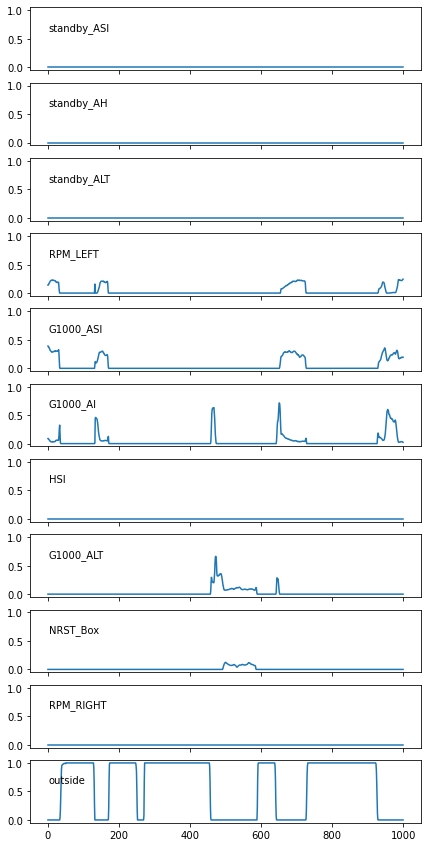

In [215]:
xs = df_x.iloc[:, 2:].values.T
# fig, axs = plt.subplots(3, 4, figsize=(15,15))
fig, axs = plt.subplots(11, sharex=True, sharey=True, figsize=(7,15))

for ax, x, k in zip(axs.reshape(-1), xs, pdict.keys()):
    ax.plot(x)
    ax.text(2, 0.65, k)
# fig.suptitle('Sharing x per column, y per row')
# ax1.plot(x, y)
# ax2.plot(x, y**2, 'tab:orange')
# ax3.plot(x, -y, 'tab:green')
# ax4.plot(x, -y**2, 'tab:red')

# for ax in fig.get_axes():
#     ax.label_outer()

In [33]:
(534 + 554)/2

544.0

In [ ]:
(633, 411), (672, 451), 652,431

# Intersection method

In [36]:
fovea_radius = 20
para_radius = 50

In [78]:
def get_fovea_parafovea(point):
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask, point, para_radius, 255, -1)

    # mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask, point, fovea_radius, 100, -1)

    fovea = np.where(mask==100)
    parafovea = np.where(mask==255)
    
    return fovea, parafovea

In [81]:
def count_intersect(A,B):
    aset = set([tuple(x) for x in A])
    bset = set([tuple(x) for x in B])
    C = np.array([x for x in aset & bset])
    
    return len(C)

In [94]:
def calculate_intersect(point, ROI):
    fovea, parafovea = get_fovea_parafovea(point)
    fovea = np.transpose(fovea)
    parafovea = np.transpose(parafovea)
    ROI = np.transpose(ROI)
    
    ifovea = count_intersect(fovea, ROI)
    iparafovea = count_intersect(parafovea, ROI)
    
    p = (ifovea*3 + iparafovea) / (len(fovea)*3 + len(parafovea))
    
    return p

In [191]:
point = (650, 450)

calculate_intersect(point, pdict["outside"])

0.0

In [160]:
count_intersect(fovea, ROI)

0

In [216]:
def calculate_intersect2(A,B):
    A_rows = A.T.view([('', A.dtype)]).T
    B_rows = B.T.view([('', B.dtype)]).T
    C = np.intersect1d(A_rows, B_rows)
    return len(C)

In [209]:
point = (650, 450)
fovea, parafovea = get_fovea_parafovea(point)
fovea = np.transpose(fovea)
parafovea = np.transpose(parafovea)
ROI = np.transpose(pdict["G1000_ASI"])

matching_rows(fovea, ROI)

ValueError: When changing to a larger dtype, its size must be a divisor of the total size in bytes of the last axis of the array.

In [210]:
L = 1000
signal_dict = {key:np.zeros(L) for key in pdict.keys()}

for i, point in enumerate(x):
    if i == L:
        break
    if i%10 == 0:
        print(i)
        
    d = [dist2((point[1],point[0]), v1,v2,type) for v1,v2,type in label.values()]
    order = np.argsort(d)
    for o in order:
        ROI = list(pdict.values())[o]
        key = list(pdict.keys())[o]
        signal_value = calculate_intersect2((point[1],point[0]), ROI)
        signal_dict[key][i] = signal_value
        if signal_value == 0:
            break

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [211]:
df_x = pd.DataFrame(x[:L], columns=['y', 'x'])
df_x = df_x[['x','y']]
df_x = pd.concat([df_x, pd.DataFrame(signal_dict)], axis = 1)

In [213]:
df_x.iloc[25:40]

,x,y,standby_ASI,standby_AH,standby_ALT,RPM_LEFT,G1000_ASI,G1000_AI,HSI,G1000_ALT,NRST_Box,RPM_RIGHT,outside
25,683,438,0.0,0.0,0.0,0.190849,0.302442,0.058017,0.0,0.00000,0.0,0.0,0.000000
26,684,437,0.0,0.0,0.0,0.182257,0.298581,0.063037,0.0,0.00000,0.0,0.0,0.000000
27,683,438,0.0,0.0,0.0,0.190849,0.302442,0.058017,0.0,0.00000,0.0,0.0,0.000000
28,683,438,0.0,0.0,0.0,0.190849,0.302442,0.058017,0.0,0.00000,0.0,0.0,0.000000
29,683,439,0.0,0.0,0.0,0.189207,0.310937,0.058596,0.0,0.00000,0.0,0.0,0.000000
30,683,441,0.0,0.0,0.0,0.185346,0.327734,0.059658,0.0,0.00000,0.0,0.0,0.000000
31,697,433,0.0,0.0,0.0,0.094797,0.254851,0.136114,0.0,0.00000,0.0,0.0,0.000000
32,712,425,0.0,0.0,0.0,0.033980,0.133700,0.263153,0.0,0.00000,0.0,0.0,0.000000
33,739,407,0.0,0.0,0.0,0.000000,0.006854,0.323969,0.0,0.00000,0.0,0.0,0.000000
34,766,390,0.0,0.0,0.0,0.000000,0.000000,0.144609,0.0,0.00029,0.0,0.0,0.042186
